In [1]:
%matplotlib inline
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

sns.set_theme(style='whitegrid', palette='muted', font_scale=0.9)

In [2]:
with h5py.File('elm-events.hdf5', 'r') as f:
    ids = list(f.keys())
    # randomly select 5 ids
    select_5_ids = np.random.choice(ids, 5)

    # signals and times corresponding to random ids
    signals = [np.array(f[i]['signals']).T for i in select_5_ids]
    times = [np.array(f[i]['time']) for i in select_5_ids]

In [3]:
def normalize_data(signal:np.ndarray):
    assert signal.shape[1] == 64, 'Signal must be reshaped into (-1, 64)'
    signal[:, :32] = signal[:, :32] / np.max(signal[:, :32])
    signal[:, 32:] = signal[:, 32:] / np.max(signal[:, 32:])
    return signal

In [4]:
signals_normalized = [normalize_data(signal) for signal in signals]

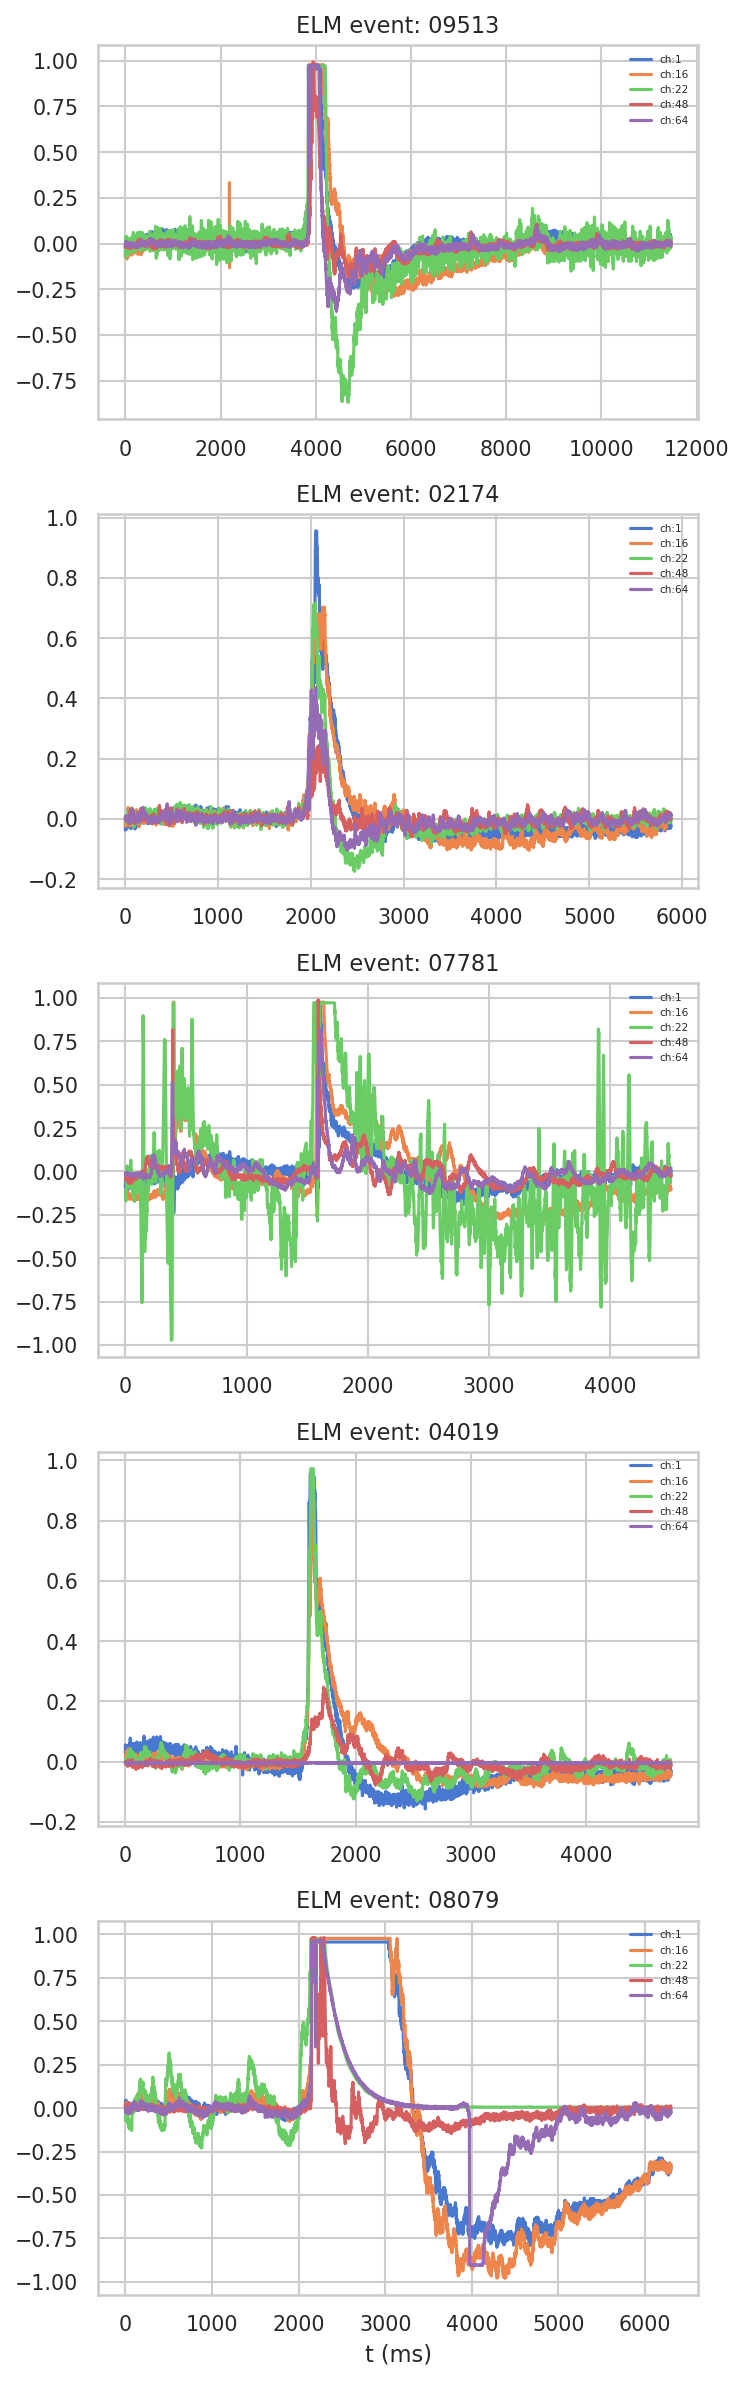

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 16), dpi=150)
ax = ax.flatten()
for j, signal in enumerate(signals_normalized):
    for i in [0, 15, 21, 47, 63]:
        ax[j].plot(signal[:, i], label=f'ch:{i+1}')
        ax[j].legend(frameon=False, fontsize=5)
        ax[j].set_title(f'ELM event: {select_5_ids[j]}')
plt.xlabel('t (ms)')
plt.tight_layout()
plt.show()

In [6]:
class Encoder(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        seq_len: int,
        n_features: int,
        n_layers: int,
        dropout: float,
    ):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            batch_first=True,
            num_layers=self.n_layers,
            dropout=self.dropout,
        )

    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        # hidden size: (num_layers, batch_size, hidden_size)
        # hidden = hidden.reshape(
        #     batch_size, -1
        # )  # (batch_size, num_layers*hidden_size)
        hidden = (
            hidden.transpose(0, 1)
            .contiguous()
            .view(-1, self.n_layers * self.hidden_dim)
        )
        return hidden


class Decoder(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        seq_len: int,
        n_features: int,
        n_layers: int,
        dropout: float,
    ):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(
            input_size=self.n_layers * self.hidden_dim,
            hidden_size=self.hidden_dim,
            batch_first=True,
            num_layers=self.n_layers,
            dropout=self.dropout,
        )
        self.fc = nn.Linear(self.hidden_dim, self.n_features)

    def forward(self, x):
        # x: (batch_size, num_layers*hidden_size)
        x = x.repeat(1, self.seq_len, 1)
        x = x.reshape(-1, self.seq_len, self.n_layers * self.hidden_dim)
        x, _ = self.rnn(x)  # x: (batch_size, seq_len, hidden_dim)
        x = self.fc(x)  # x: (batch_size, seq_len, n_features)

        return x


class LSTMAutoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions for both encoder and decoder must be equal"

        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder should have same number of layers"

    def forward(self, input):
        # input = torch.unsqueeze(input, 0)
        # encode
        hidden = self.encoder(input)
        # decode
        y = self.decoder(hidden)

        return y.squeeze(0)

In [7]:
def temporalize(sws:int, signals:np.ndarray):
    X_unlabeled = []
    for i in range(len(signals) - sws + 1):
        X_unlabeled.append(signals[i:i+sws])
    X_unlabeled = np.array(X_unlabeled)
    return X_unlabeled

In [8]:
seq_len = 16
n_features = 64
n_layers = 2
pct = 0.3
hidden_dim = 32
encoder = Encoder(
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_features=n_features,
    n_layers=n_layers,
    dropout=pct,
)
decoder = Decoder(
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_features=n_features,
    n_layers=n_layers,
    dropout=pct,
)
model = LSTMAutoencoder(encoder, decoder)
model

LSTMAutoencoder(
  (encoder): Encoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.3)
    (fc): Linear(in_features=32, out_features=64, bias=True)
  )
)

In [9]:
base_path = os.path.dirname(os.getcwd())
saved_model_path = 'elm_classification/model_checkpoints/signal_window_16/lstm_ae_sws_16_la_0.pth'
model_ckpt_path = os.path.join(base_path, saved_model_path)
print(f'Loading model from:\n{model_ckpt_path}')
device = torch.device("cpu")
model = model.to(device)
model.load_state_dict(
        torch.load(
            model_ckpt_path,
            map_location=device,
        )
    )

Loading model from:
/home/lakshya/research/bes_edgeml_models/elm_classification/model_checkpoints/signal_window_16/lstm_ae_sws_16_la_0.pth


<All keys matched successfully>

In [10]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[0])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [11]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

# threshold = 0.026
threshold = 0.06
error_df = pd.DataFrame(
        {
            "reconstruction_error": mae,
            "reconstruction_error_scaled": mae / np.max(mae),
            "ch_22": sequences,
        }
    )
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.015087,0.022923,-0.042141,0
1,0.015101,0.022944,-0.041310,0
2,0.015730,0.023900,-0.061846,0
3,0.015501,0.023552,-0.048195,0
4,0.015091,0.022929,-0.033831,0
...,...,...,...,...
11441,0.015443,0.023464,0.023979,0
11442,0.016018,0.024338,0.012464,0
11443,0.015218,0.023123,0.023623,0
11444,0.015916,0.024182,0.018874,0


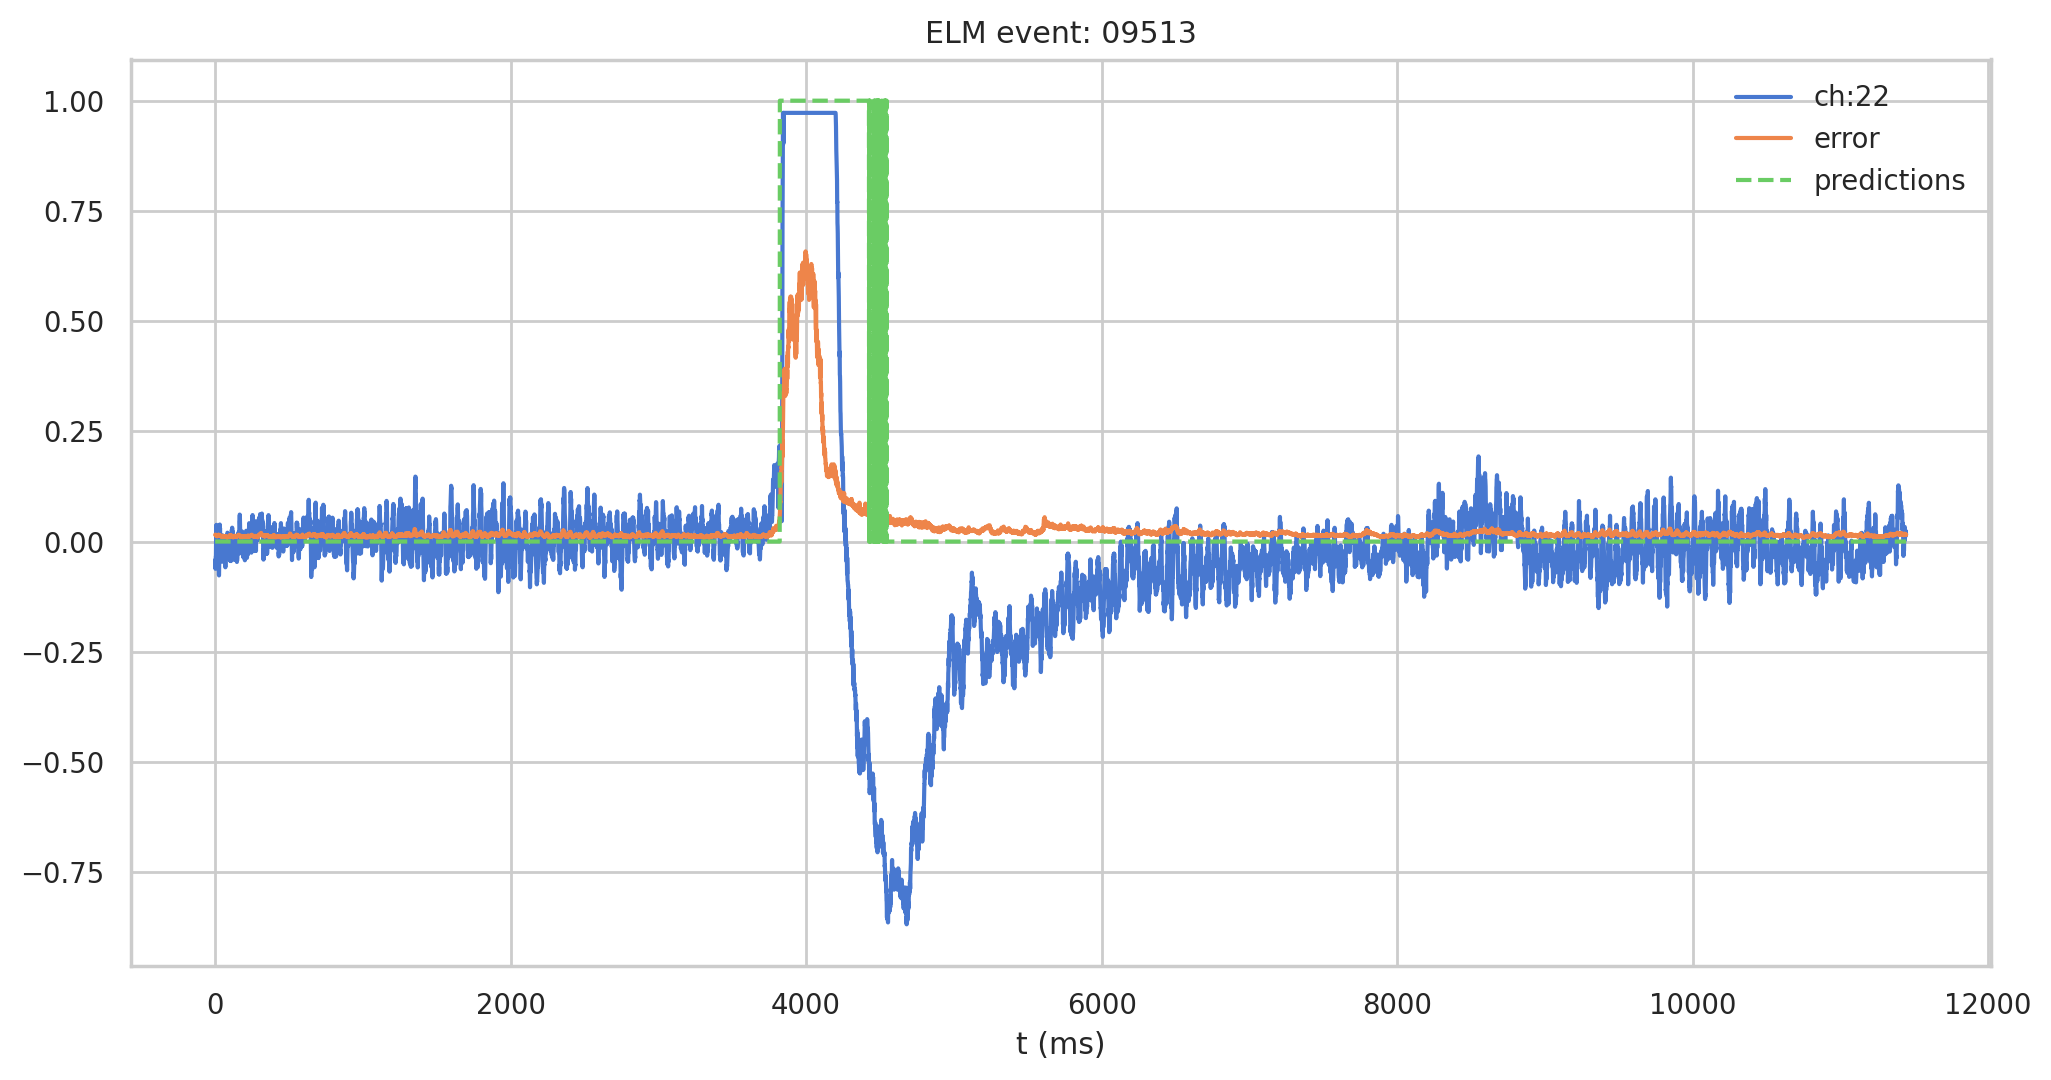

In [12]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[0]}')
plt.xlabel('t (ms)')
plt.show();

In [13]:
predictions = error_df['predictions'].values
fixed_predictions = np.zeros_like(predictions, dtype=np.int16)
non_zero_idx = np.where(predictions > 0)[0]

In [14]:
pd.DataFrame({'index': non_zero_idx, 'diff': np.diff(non_zero_idx, append=np.nan)})

,index,diff
0,3822,1.0
1,3823,1.0
2,3824,1.0
3,3825,1.0
4,3826,1.0
...,...,...
644,4532,2.0
645,4534,2.0
646,4536,4.0
647,4540,5.0


In [15]:
idx_diff = np.diff(non_zero_idx, append=np.nan)

In [16]:
active_elm_end = np.where(idx_diff > 25)[0][0]

In [17]:
active_elm_idx = non_zero_idx[:active_elm_end]#np.where(idx_diff <= 10)[0]]

In [18]:
fixed_predictions[active_elm_idx] = 1

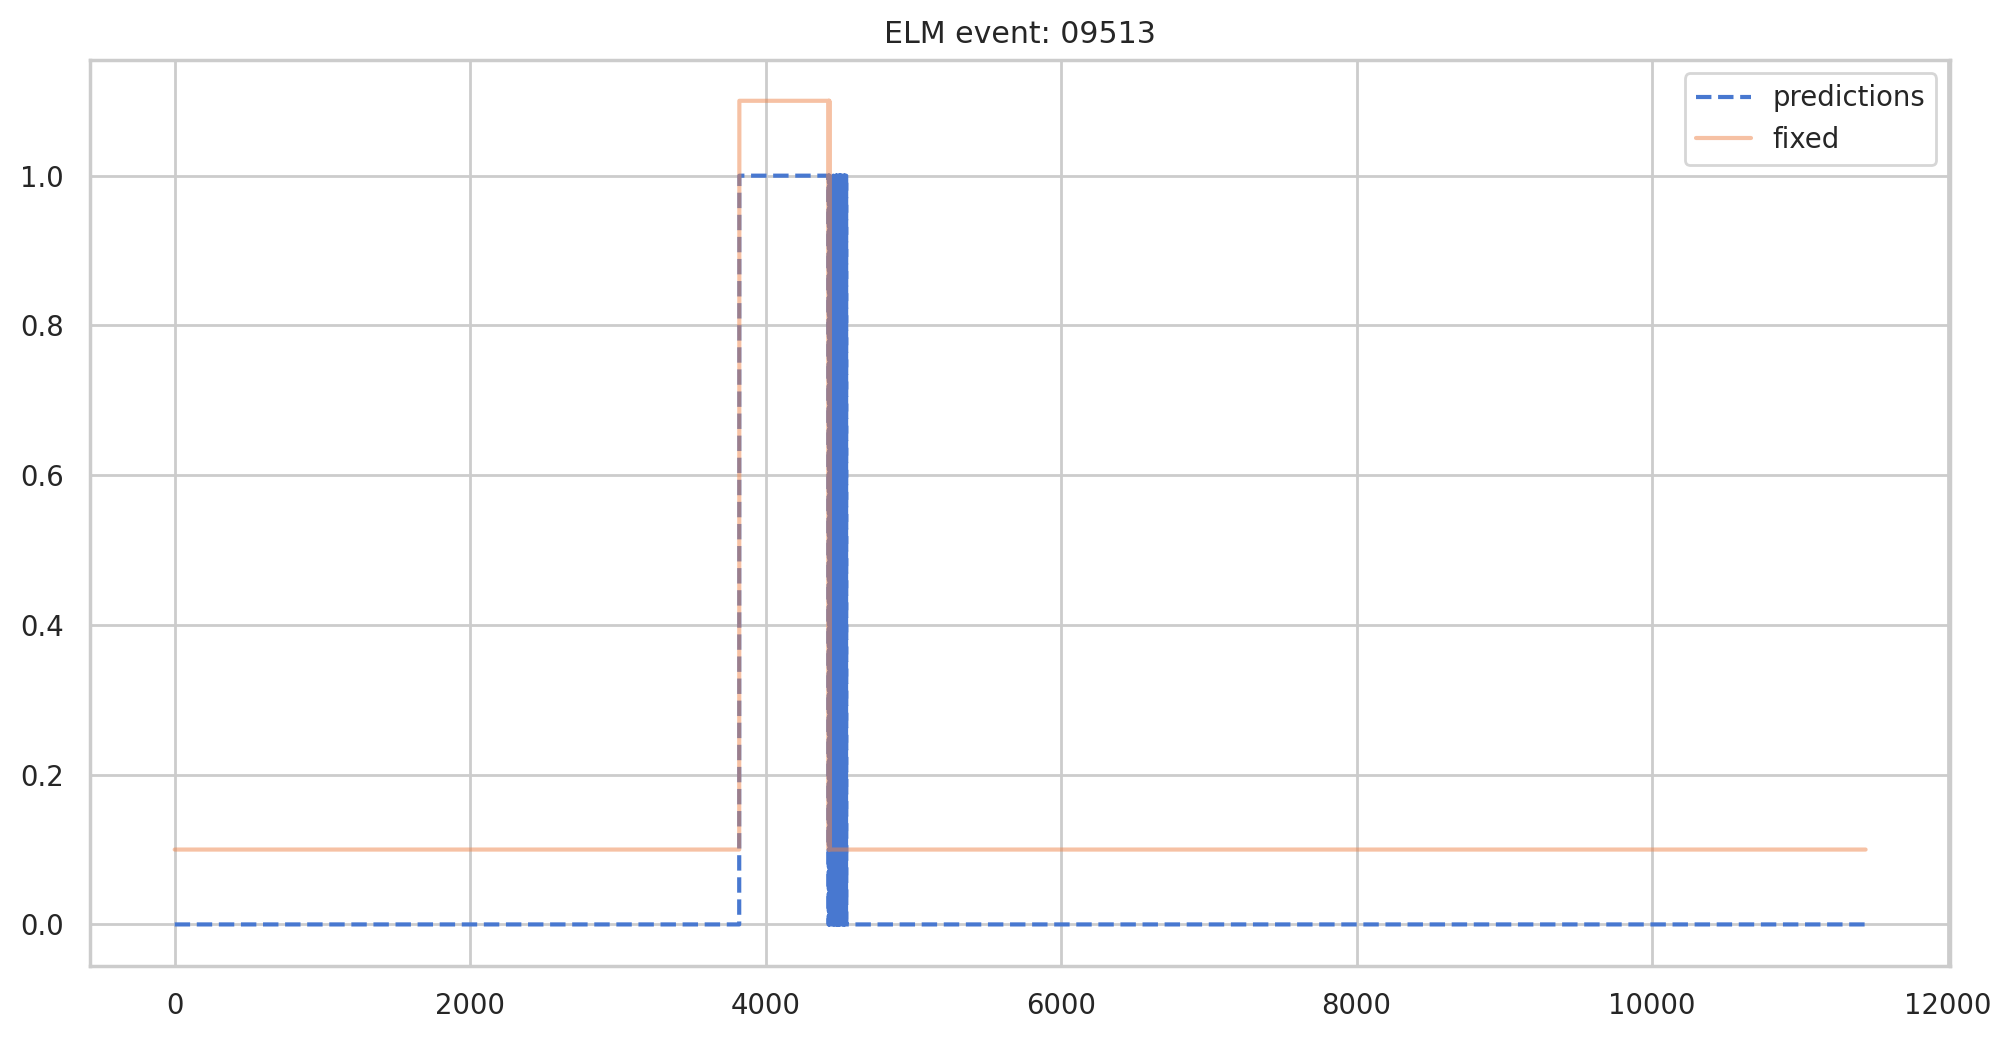

In [19]:
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(predictions, ls='--', label='predictions')
plt.plot(fixed_predictions+0.1, alpha=0.5, label='fixed')
plt.title(f'ELM event: {select_5_ids[0]}')
plt.legend()
plt.show()

In [20]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[1])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [21]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

threshold = 0.06
error_df = pd.DataFrame(
        {
            "reconstruction_error": mae,
            "reconstruction_error_scaled": mae / np.max(mae),
            "ch_22": sequences,
        }
    )
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.008740,0.021953,-0.002137,0
1,0.009194,0.023094,-0.001781,0
2,0.007557,0.018980,-0.002968,0
3,0.008139,0.020443,0.009615,0
4,0.008820,0.022153,-0.002730,0
...,...,...,...,...
5861,0.009155,0.022995,0.002137,0
5862,0.008693,0.021836,-0.011871,0
5863,0.008287,0.020814,0.003205,0
5864,0.008475,0.021288,-0.009378,0


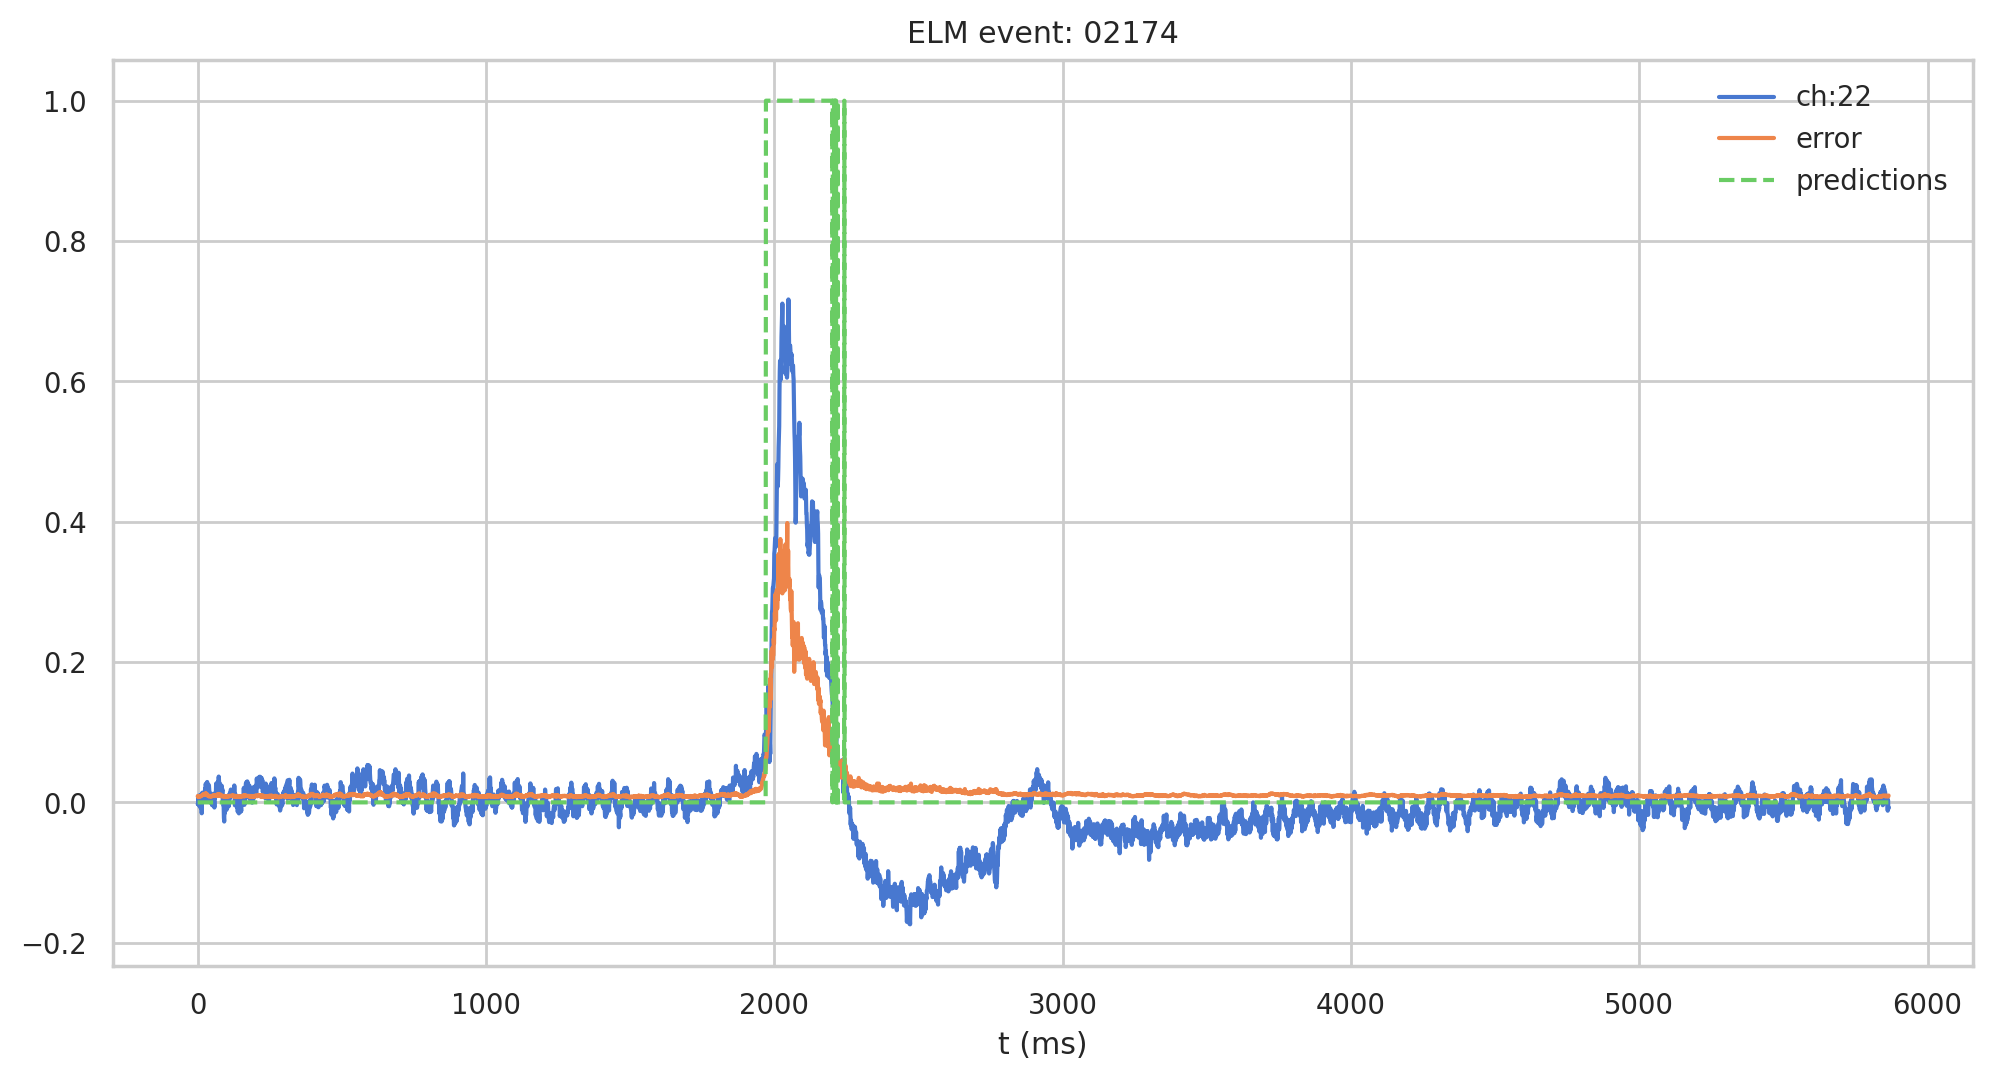

In [22]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[1]}')
plt.xlabel('t (ms)')
plt.show()

In [23]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[2])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [24]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

# threshold = 0.026
threshold = 0.06
error_df = pd.DataFrame(
    {
        "reconstruction_error": mae,
        "reconstruction_error_scaled": mae / np.max(mae),
        "ch_22": sequences,
    }
)
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.025739,0.046957,-0.112771,0
1,0.024600,0.044878,-0.126897,0
2,0.023867,0.043542,-0.134850,0
3,0.025185,0.045946,-0.154437,0
4,0.025929,0.047303,-0.161796,0
...,...,...,...,...
4481,0.024374,0.044466,0.078465,0
4482,0.024641,0.044953,0.087486,0
4483,0.024356,0.044433,0.096745,0
4484,0.024629,0.044932,0.063508,0


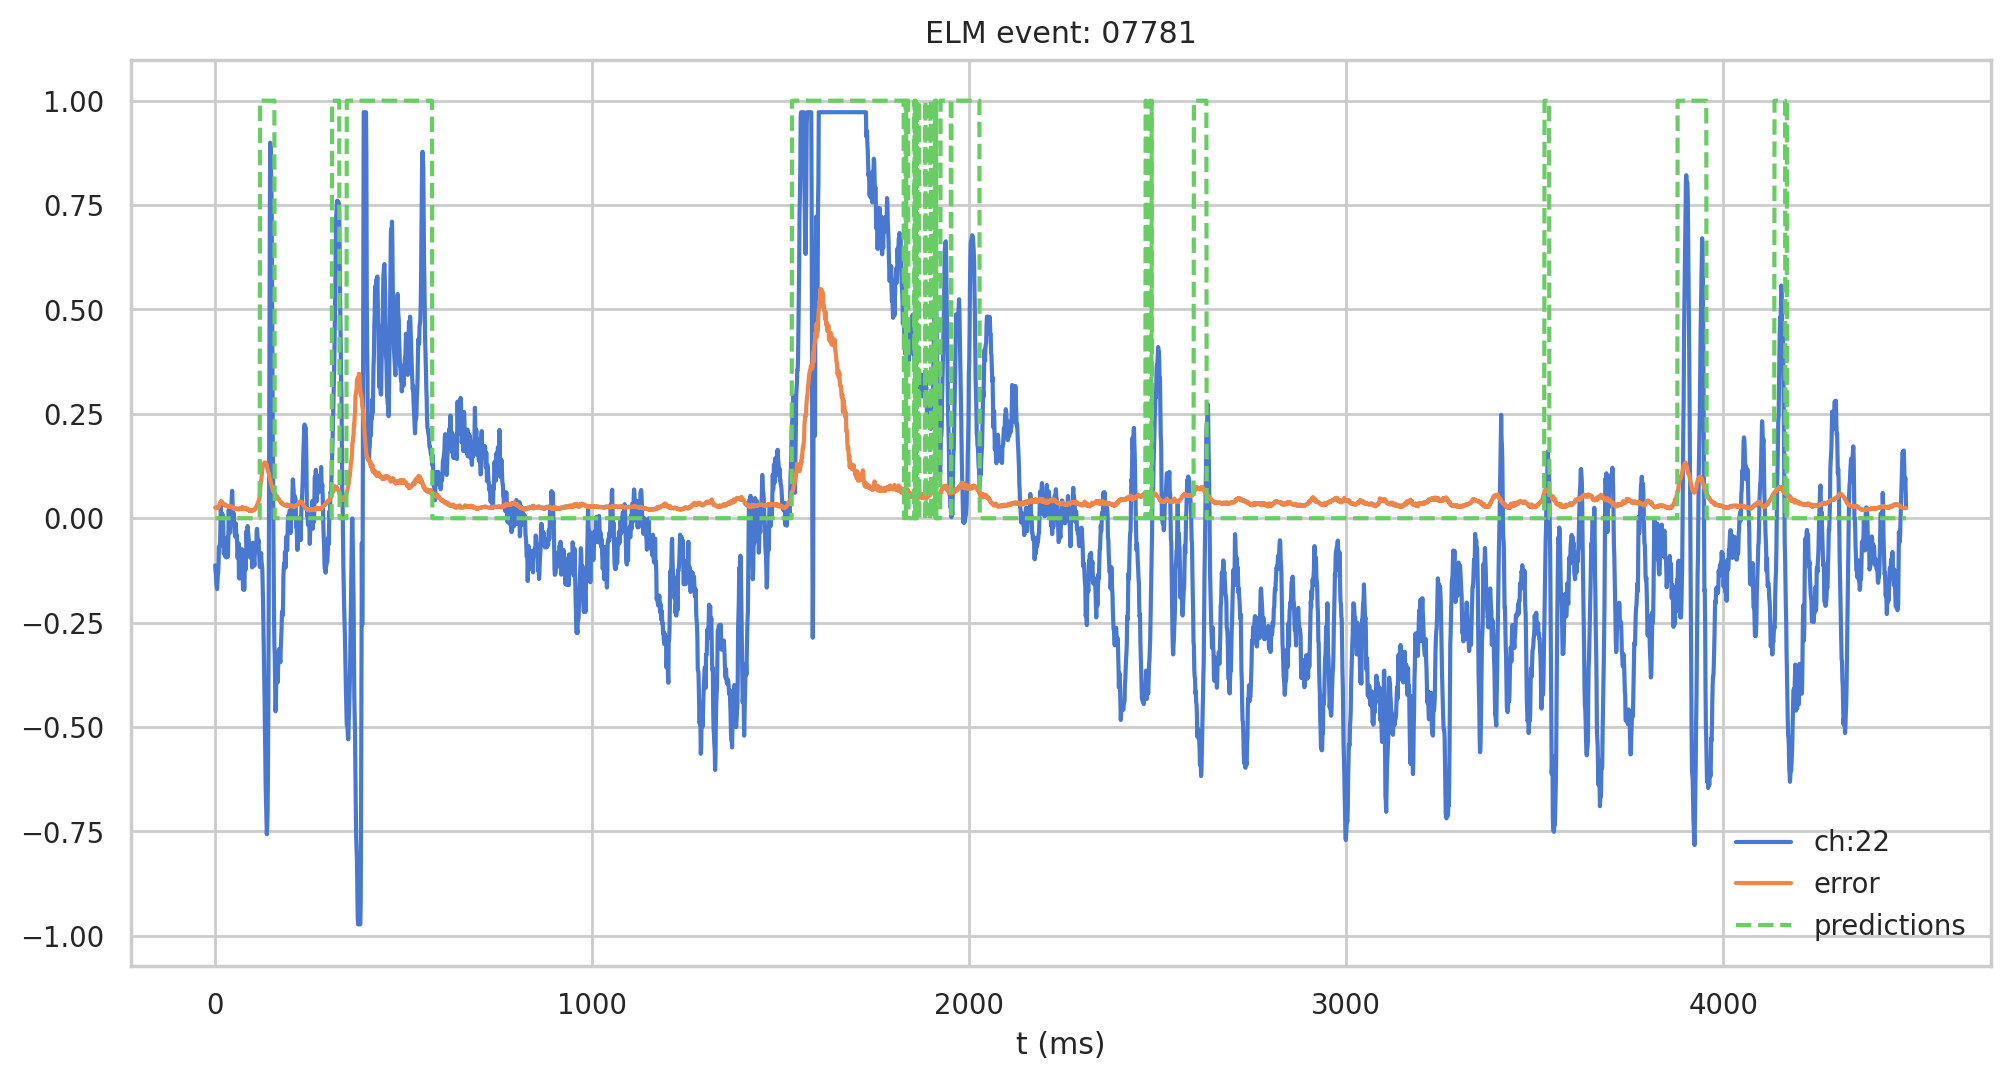

In [25]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[2]}')
plt.xlabel('t (ms)')
plt.show()

In [26]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[3])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [27]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

# threshold = 0.026
threshold = 0.06
error_df = pd.DataFrame(
    {
        "reconstruction_error": mae,
        "reconstruction_error_scaled": mae / np.max(mae),
        "ch_22": sequences,
    }
)
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.013922,0.024392,0.002730,0
1,0.013077,0.022911,0.004630,0
2,0.013148,0.023036,-0.002968,0
3,0.013210,0.023144,-0.007716,0
4,0.012982,0.022746,-0.002374,0
...,...,...,...,...
4721,0.011213,0.019646,-0.009971,0
4722,0.011201,0.019624,-0.008072,0
4723,0.010667,0.018688,-0.007004,0
4724,0.010591,0.018556,-0.002612,0


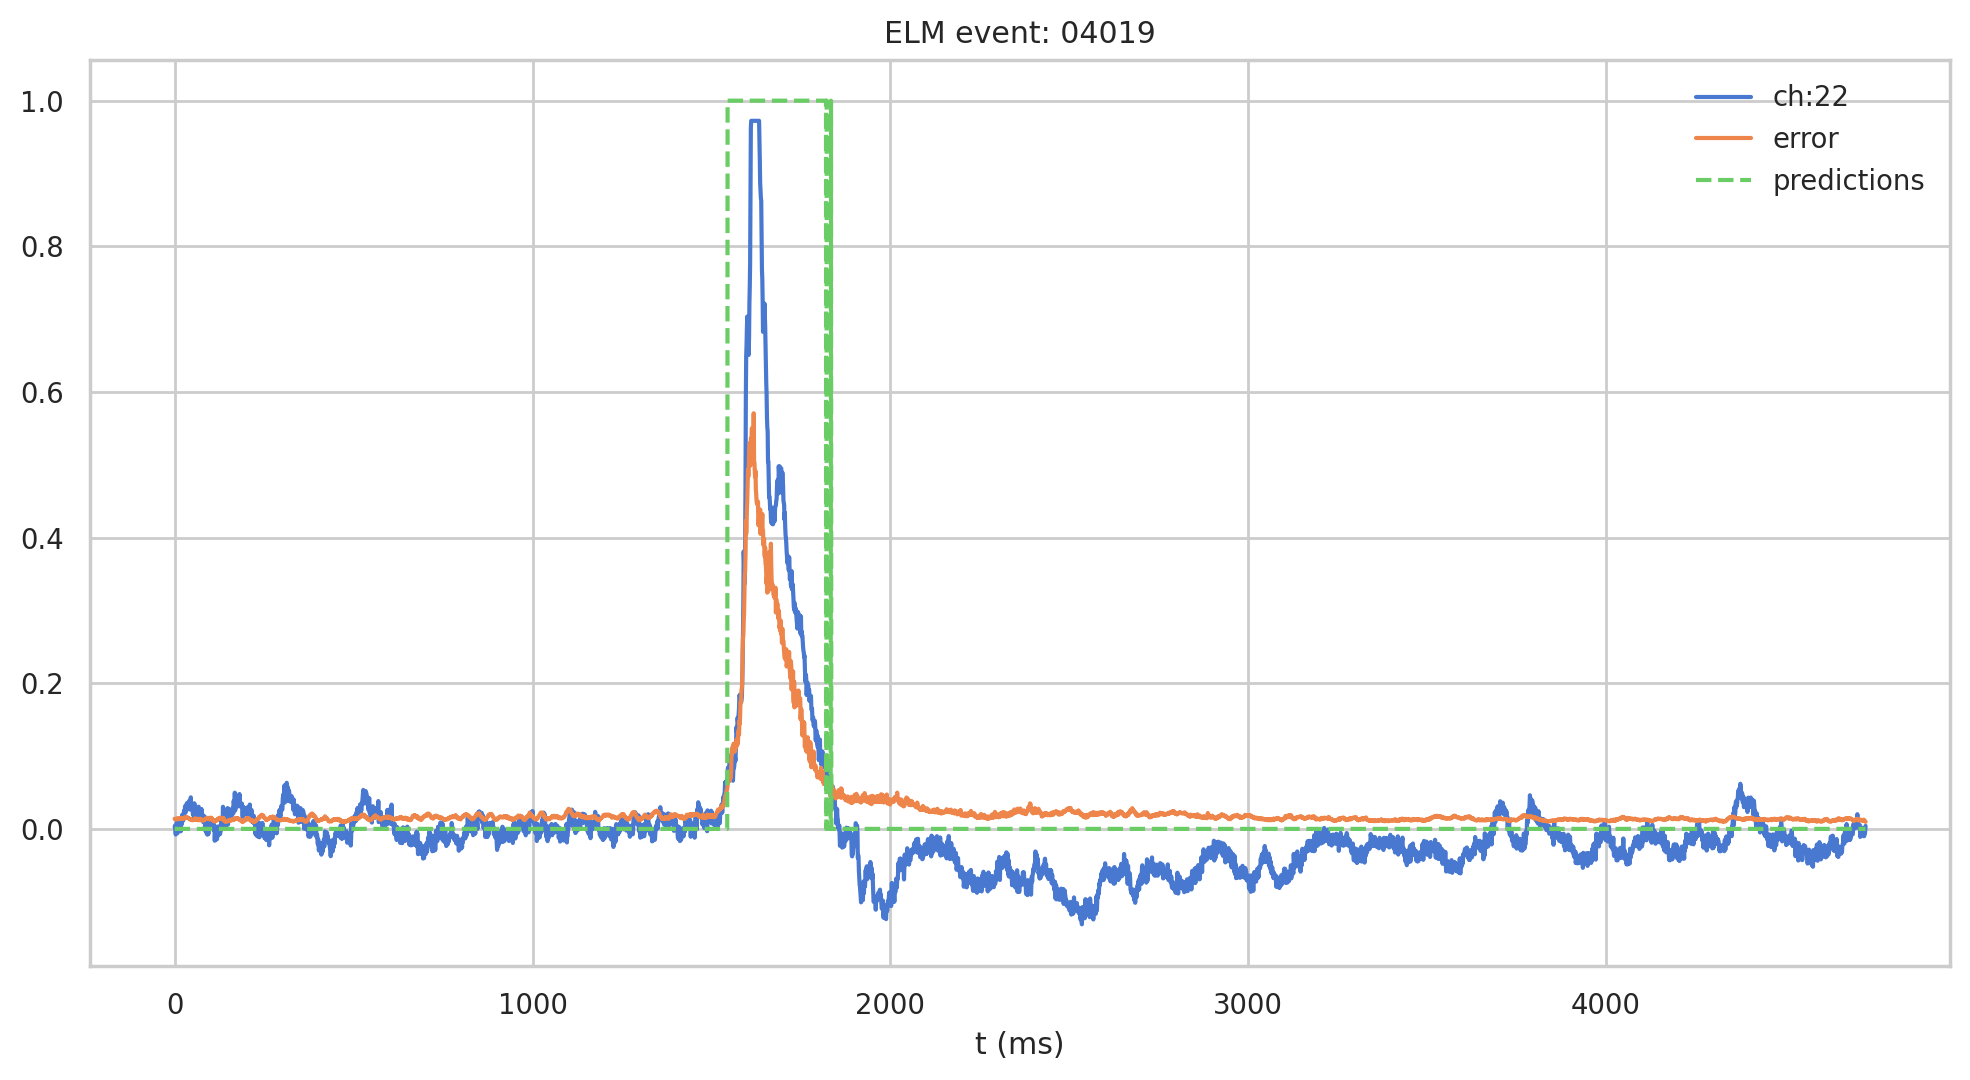

In [28]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[3]}')
plt.xlabel('t (ms)')
plt.show()